In [1]:
import numpy as np
from src.leak_model import BackgroundLeakSegmenter
import torch
import cv2
from torch.utils.data import Dataset
import lightning as L

class FrameDataset(Dataset):
    def __init__(self, frames_array):
        # Convert numpy frames to tensor format
        frames_rgb = frames_array[:, :, :, ::-1]  # BGR to RGB
        # Use torch.from_numpy with copy to avoid negative stride issues
        self.frames = torch.from_numpy(frames_rgb.copy()).float().permute(0, 3, 1, 2) / 255.0
    
    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        return {'frames': self.frames}


def reconstruct(frames: list) -> np.ndarray:
    # TODO:
    # Reconstruct the surroundings in the video that are concealed by a virtual background.
    # Return the reconstructed background image as a numpy array of shape (720, 1280, 3).

    # Convert list of frames to numpy array
    frames_array = np.array(frames)  # Shape: (num_frames, height, width, 3) BGR

    # Load model and create trainer
    model = BackgroundLeakSegmenter.load_from_checkpoint('lightning_logs/version_5/checkpoints/best-epoch=23-val_loss=0.155.ckpt')
    trainer = L.Trainer(accelerator='auto', devices=1)

    # Create dataset and dataloader
    dataset = FrameDataset(frames_array)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

    # Run prediction
    predictions = trainer.predict(model, dataloader)
    reconstructed_tensor = predictions[0][0] # type: ignore # Get first batch, first item

    # Convert back to numpy BGR
    reconstructed_np = reconstructed_tensor.permute(1, 2, 0).numpy() * 255
    reconstructed_bg = cv2.cvtColor(reconstructed_np.astype(np.uint8), cv2.COLOR_RGB2BGR)

    return reconstructed_bg # the reconstructed background image

In [2]:
from src.util import load_video

video = np.array(load_video("data/public/videos/2_i_kitchen_bridge_mp.mp4"))
video.shape, type(video)

((360, 720, 1280, 3), numpy.ndarray)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jlb/Projects/RAID/wave2_vader/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('med

Predicting: |          | 0/? [00:00<?, ?it/s]

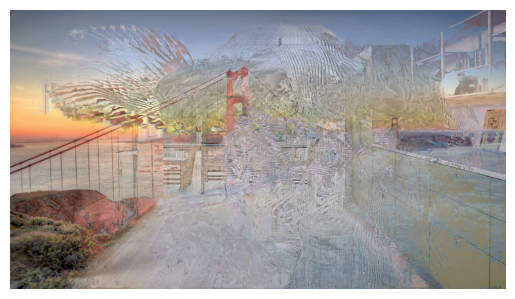

In [3]:
reconstructed_bg = reconstruct(video)
# Display the reconstructed background image
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(reconstructed_bg, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
